# Medical Image Classification with MONAI

In [1]:
from tqdm import tqdm
import numpy as np
import os
import PIL
import time
import psutil
import shutil
import tempfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report

import medmnist
from medmnist import INFO, Evaluator

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, Dataset
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121, resnet, resnet18
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    EnsureChannelFirst,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    RandGaussianNoise,
    RandAdjustContrast,
    ScaleIntensity, 
    Transform,
    ToTensor,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.dev2441
Numpy version: 1.26.3
Pytorch version: 2.2.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cf815ed4e44a5b8ce67e894ab0bc2765279a1a59
MONAI __file__: /mnt/hdd/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.25.1
scipy version: 1.15.1
Pillow version: 10.2.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.48.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the o

## Continue working with OrganMNIST3d 64x64x64

In [2]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 70
BATCH_SIZE = 8
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)
val_dataset = DataClass(split='val', download=download, size=64)
test_dataset = DataClass(split='test', download=download, size=64)

Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz


In [3]:
root_dir = '/mnt/hdd/marina/.medmnist/'

In [4]:
train_dataset

Dataset OrganMNIST3D of size 64 (organmnist3d_64)
    Number of datapoints: 971
    Root location: /mnt/hdd/marina/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
    Number of samples: {'train': 971, 'val': 161, 'test': 610}
    Description: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
    License: CC BY 4.0

## Define transforms

In [5]:
train_transforms = Compose(
    [
        ScaleIntensity(),
        RandGaussianNoise(prob=0.5, mean=0.0, std=0.05),
        RandAdjustContrast(gamma=(0.7, 1.3), prob=0.5),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
        EnsureType(),
    ]
)

val_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

test_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=n_classes)])

In [6]:
class _3D_Dataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]

        if self.transform:
            data = self.transform(data)

        return {'images': data, 'label': label}

In [7]:
train_dataset_ = _3D_Dataset(train_dataset, transform=train_transforms)
val_dataset_ = _3D_Dataset(val_dataset, transform=val_transforms)
test_dataset_ = _3D_Dataset(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)

## Training cycle

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=False, spatial_dims=3, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 110
val_interval = 1
auc_metric = ROCAUCMetric()

In [42]:
print(model)

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [38]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    batch_iter = tqdm(train_loader, desc="Training Batches", leave=True, dynamic_ncols=True, ascii=True)
    
    for batch_data in batch_iter:
        step += 1
        images, labels = batch_data['images'].to(device), batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        batch_iter.set_postfix(train_loss=loss.item())
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    tqdm.write(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'].to(device),
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_3d.pth"))
                tqdm.write("Saved new best metric model")
            tqdm.write(
                f"Current epoch: {epoch + 1} | AUC: {result:.4f} | "
                f"Accuracy: {acc_metric:.4f} | Best AUC: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

tqdm.write(f"Train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/110


Training Batches: 100%|##########| 122/122 [00:23<00:00,  5.11it/s, train_loss=2.11] 


Epoch 1 average loss: 1.5370
Saved new best metric model
Current epoch: 1 | AUC: 0.9594 | Accuracy: 0.4658 | Best AUC: 0.9594 at epoch: 1
----------
epoch 2/110


Training Batches: 100%|##########| 122/122 [00:23<00:00,  5.09it/s, train_loss=0.795]


Epoch 2 average loss: 1.0144
Saved new best metric model
Current epoch: 2 | AUC: 0.9766 | Accuracy: 0.6087 | Best AUC: 0.9766 at epoch: 2
----------
epoch 3/110


Training Batches: 100%|##########| 122/122 [00:23<00:00,  5.16it/s, train_loss=0.714]


Epoch 3 average loss: 0.8279
Saved new best metric model
Current epoch: 3 | AUC: 0.9906 | Accuracy: 0.8261 | Best AUC: 0.9906 at epoch: 3
----------
epoch 4/110


Training Batches: 100%|##########| 122/122 [00:23<00:00,  5.15it/s, train_loss=1.63] 


Epoch 4 average loss: 0.6839
Current epoch: 4 | AUC: 0.9794 | Accuracy: 0.5590 | Best AUC: 0.9906 at epoch: 3
----------
epoch 5/110


Training Batches: 100%|##########| 122/122 [00:23<00:00,  5.09it/s, train_loss=1.39]  


Epoch 5 average loss: 0.5928
Current epoch: 5 | AUC: 0.9842 | Accuracy: 0.7143 | Best AUC: 0.9906 at epoch: 3
----------
epoch 6/110


Training Batches: 100%|##########| 122/122 [00:23<00:00,  5.15it/s, train_loss=0.852]


Epoch 6 average loss: 0.5463
Saved new best metric model
Current epoch: 6 | AUC: 0.9908 | Accuracy: 0.7267 | Best AUC: 0.9908 at epoch: 6
----------
epoch 7/110


Training Batches: 100%|##########| 122/122 [00:23<00:00,  5.20it/s, train_loss=0.29] 


Epoch 7 average loss: 0.5179
Saved new best metric model
Current epoch: 7 | AUC: 0.9954 | Accuracy: 0.8944 | Best AUC: 0.9954 at epoch: 7
----------
epoch 8/110


Training Batches: 100%|##########| 122/122 [00:23<00:00,  5.10it/s, train_loss=0.359]


Epoch 8 average loss: 0.5101
Current epoch: 8 | AUC: 0.9911 | Accuracy: 0.7640 | Best AUC: 0.9954 at epoch: 7
----------
epoch 9/110


Training Batches: 100%|##########| 122/122 [00:23<00:00,  5.09it/s, train_loss=0.313] 


Epoch 9 average loss: 0.4512
Saved new best metric model
Current epoch: 9 | AUC: 0.9991 | Accuracy: 0.9317 | Best AUC: 0.9991 at epoch: 9
----------
epoch 10/110


Training Batches: 100%|##########| 122/122 [00:23<00:00,  5.10it/s, train_loss=0.367]


Epoch 10 average loss: 0.4090
Current epoch: 10 | AUC: 0.9987 | Accuracy: 0.9317 | Best AUC: 0.9991 at epoch: 9
----------
epoch 11/110


Training Batches: 100%|##########| 122/122 [00:23<00:00,  5.11it/s, train_loss=3.91]  


Epoch 11 average loss: 0.4319
Current epoch: 11 | AUC: 0.9974 | Accuracy: 0.8758 | Best AUC: 0.9991 at epoch: 9
----------
epoch 12/110


Training Batches: 100%|##########| 122/122 [00:23<00:00,  5.10it/s, train_loss=0.475] 


Epoch 12 average loss: 0.4094
Current epoch: 12 | AUC: 0.9958 | Accuracy: 0.8447 | Best AUC: 0.9991 at epoch: 9
----------
epoch 13/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.06it/s, train_loss=0.892] 


Epoch 13 average loss: 0.3545


Exception ignored in: <function tqdm.__del__ at 0x7fc493b09630>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/opt/conda/lib/python3.10/site-packages/tqdm/std.py", line 1277, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'
Exception ignored in: <function tqdm.__del__ at 0x7fc493b09630>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/opt/conda/lib/python3.10/site-packages/tqdm/std.py", line 1277, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'
Exception ignored in: <function tqdm.__del__ at 0x7fc493b09630>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  Fi

Current epoch: 13 | AUC: 0.9979 | Accuracy: 0.9130 | Best AUC: 0.9991 at epoch: 9
----------
epoch 14/110


Training Batches: 100%|##########| 122/122 [00:23<00:00,  5.11it/s, train_loss=2.55]  


Epoch 14 average loss: 0.3550
Current epoch: 14 | AUC: 0.9969 | Accuracy: 0.8199 | Best AUC: 0.9991 at epoch: 9
----------
epoch 15/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.04it/s, train_loss=0.379] 


Epoch 15 average loss: 0.3306
Current epoch: 15 | AUC: 0.9973 | Accuracy: 0.8944 | Best AUC: 0.9991 at epoch: 9
----------
epoch 16/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.06it/s, train_loss=0.0307]


Epoch 16 average loss: 0.2969
Current epoch: 16 | AUC: 0.9957 | Accuracy: 0.9193 | Best AUC: 0.9991 at epoch: 9
----------
epoch 17/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.99it/s, train_loss=0.0548]


Epoch 17 average loss: 0.3214
Current epoch: 17 | AUC: 0.9881 | Accuracy: 0.8012 | Best AUC: 0.9991 at epoch: 9
----------
epoch 18/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.06it/s, train_loss=0.697] 


Epoch 18 average loss: 0.2893
Current epoch: 18 | AUC: 0.9925 | Accuracy: 0.8509 | Best AUC: 0.9991 at epoch: 9
----------
epoch 19/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.03it/s, train_loss=1.62]  


Epoch 19 average loss: 0.2544
Current epoch: 19 | AUC: 0.9919 | Accuracy: 0.8385 | Best AUC: 0.9991 at epoch: 9
----------
epoch 20/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.98it/s, train_loss=0.501] 


Epoch 20 average loss: 0.2588
Current epoch: 20 | AUC: 0.9971 | Accuracy: 0.9130 | Best AUC: 0.9991 at epoch: 9
----------
epoch 21/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.98it/s, train_loss=0.596] 


Epoch 21 average loss: 0.2512
Current epoch: 21 | AUC: 0.9924 | Accuracy: 0.9068 | Best AUC: 0.9991 at epoch: 9
----------
epoch 22/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.03it/s, train_loss=0.0174]


Epoch 22 average loss: 0.2408
Current epoch: 22 | AUC: 0.9950 | Accuracy: 0.9441 | Best AUC: 0.9991 at epoch: 9
----------
epoch 23/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.05it/s, train_loss=0.163] 


Epoch 23 average loss: 0.2113
Current epoch: 23 | AUC: 0.9931 | Accuracy: 0.9130 | Best AUC: 0.9991 at epoch: 9
----------
epoch 24/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.02it/s, train_loss=0.489] 


Epoch 24 average loss: 0.2084
Current epoch: 24 | AUC: 0.9912 | Accuracy: 0.8696 | Best AUC: 0.9991 at epoch: 9
----------
epoch 25/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.98it/s, train_loss=0.134] 


Epoch 25 average loss: 0.2271
Current epoch: 25 | AUC: 0.9967 | Accuracy: 0.8944 | Best AUC: 0.9991 at epoch: 9
----------
epoch 26/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.96it/s, train_loss=1.17]  


Epoch 26 average loss: 0.2030
Current epoch: 26 | AUC: 0.9987 | Accuracy: 0.8758 | Best AUC: 0.9991 at epoch: 9
----------
epoch 27/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.04it/s, train_loss=0.0181] 


Epoch 27 average loss: 0.2310
Current epoch: 27 | AUC: 0.9865 | Accuracy: 0.8571 | Best AUC: 0.9991 at epoch: 9
----------
epoch 28/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.04it/s, train_loss=0.59]  


Epoch 28 average loss: 0.1628
Current epoch: 28 | AUC: 0.9850 | Accuracy: 0.8571 | Best AUC: 0.9991 at epoch: 9
----------
epoch 29/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.07it/s, train_loss=0.195]  


Epoch 29 average loss: 0.1635
Current epoch: 29 | AUC: 0.9964 | Accuracy: 0.9130 | Best AUC: 0.9991 at epoch: 9
----------
epoch 30/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.00it/s, train_loss=0.501]  


Epoch 30 average loss: 0.1449
Current epoch: 30 | AUC: 0.9925 | Accuracy: 0.8509 | Best AUC: 0.9991 at epoch: 9
----------
epoch 31/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.02it/s, train_loss=0.968]  


Epoch 31 average loss: 0.1660
Current epoch: 31 | AUC: 0.9905 | Accuracy: 0.9068 | Best AUC: 0.9991 at epoch: 9
----------
epoch 32/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.03it/s, train_loss=0.0683]


Epoch 32 average loss: 0.1575
Current epoch: 32 | AUC: 0.9915 | Accuracy: 0.9255 | Best AUC: 0.9991 at epoch: 9
----------
epoch 33/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.00it/s, train_loss=0.0239] 


Epoch 33 average loss: 0.1319
Current epoch: 33 | AUC: 0.9966 | Accuracy: 0.9006 | Best AUC: 0.9991 at epoch: 9
----------
epoch 34/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.02it/s, train_loss=0.29]   


Epoch 34 average loss: 0.1242
Current epoch: 34 | AUC: 0.9959 | Accuracy: 0.9068 | Best AUC: 0.9991 at epoch: 9
----------
epoch 35/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.02it/s, train_loss=0.12]  


Epoch 35 average loss: 0.1244
Current epoch: 35 | AUC: 0.9854 | Accuracy: 0.8696 | Best AUC: 0.9991 at epoch: 9
----------
epoch 36/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.08it/s, train_loss=0.0832]


Epoch 36 average loss: 0.1190
Current epoch: 36 | AUC: 0.9822 | Accuracy: 0.8447 | Best AUC: 0.9991 at epoch: 9
----------
epoch 37/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.00it/s, train_loss=1.34]  


Epoch 37 average loss: 0.1537
Current epoch: 37 | AUC: 0.9930 | Accuracy: 0.9006 | Best AUC: 0.9991 at epoch: 9
----------
epoch 38/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.01it/s, train_loss=0.0861] 


Epoch 38 average loss: 0.1109
Current epoch: 38 | AUC: 0.9902 | Accuracy: 0.8758 | Best AUC: 0.9991 at epoch: 9
----------
epoch 39/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.00it/s, train_loss=0.00485]


Epoch 39 average loss: 0.1045
Current epoch: 39 | AUC: 0.9852 | Accuracy: 0.8261 | Best AUC: 0.9991 at epoch: 9
----------
epoch 40/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.98it/s, train_loss=0.0884]


Epoch 40 average loss: 0.1120
Current epoch: 40 | AUC: 0.9809 | Accuracy: 0.8571 | Best AUC: 0.9991 at epoch: 9
----------
epoch 41/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.07it/s, train_loss=0.0845] 


Epoch 41 average loss: 0.1100
Current epoch: 41 | AUC: 0.9951 | Accuracy: 0.9130 | Best AUC: 0.9991 at epoch: 9
----------
epoch 42/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.05it/s, train_loss=0.029]  


Epoch 42 average loss: 0.0981
Current epoch: 42 | AUC: 0.9970 | Accuracy: 0.9130 | Best AUC: 0.9991 at epoch: 9
----------
epoch 43/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.06it/s, train_loss=0.145]  


Epoch 43 average loss: 0.0680
Current epoch: 43 | AUC: 0.9900 | Accuracy: 0.8696 | Best AUC: 0.9991 at epoch: 9
----------
epoch 44/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.01it/s, train_loss=1.2]    


Epoch 44 average loss: 0.0977
Current epoch: 44 | AUC: 0.9927 | Accuracy: 0.9130 | Best AUC: 0.9991 at epoch: 9
----------
epoch 45/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.01it/s, train_loss=1.62]   


Epoch 45 average loss: 0.1480
Current epoch: 45 | AUC: 0.9896 | Accuracy: 0.8758 | Best AUC: 0.9991 at epoch: 9
----------
epoch 46/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.99it/s, train_loss=0.176]  


Epoch 46 average loss: 0.1215
Current epoch: 46 | AUC: 0.9932 | Accuracy: 0.8447 | Best AUC: 0.9991 at epoch: 9
----------
epoch 47/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.01it/s, train_loss=0.029]  


Epoch 47 average loss: 0.0994
Current epoch: 47 | AUC: 0.9912 | Accuracy: 0.8758 | Best AUC: 0.9991 at epoch: 9
----------
epoch 48/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.01it/s, train_loss=2.69]   


Epoch 48 average loss: 0.1149
Current epoch: 48 | AUC: 0.9937 | Accuracy: 0.9006 | Best AUC: 0.9991 at epoch: 9
----------
epoch 49/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.04it/s, train_loss=0.0291] 


Epoch 49 average loss: 0.0887
Current epoch: 49 | AUC: 0.9894 | Accuracy: 0.8882 | Best AUC: 0.9991 at epoch: 9
----------
epoch 50/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.03it/s, train_loss=1.24]   


Epoch 50 average loss: 0.0986
Current epoch: 50 | AUC: 0.9919 | Accuracy: 0.9193 | Best AUC: 0.9991 at epoch: 9
----------
epoch 51/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.97it/s, train_loss=0.0142] 


Epoch 51 average loss: 0.0505
Current epoch: 51 | AUC: 0.9972 | Accuracy: 0.9565 | Best AUC: 0.9991 at epoch: 9
----------
epoch 52/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.02it/s, train_loss=0.00494]


Epoch 52 average loss: 0.0494
Current epoch: 52 | AUC: 0.9942 | Accuracy: 0.9193 | Best AUC: 0.9991 at epoch: 9
----------
epoch 53/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.04it/s, train_loss=0.315]  


Epoch 53 average loss: 0.0725
Current epoch: 53 | AUC: 0.9937 | Accuracy: 0.9130 | Best AUC: 0.9991 at epoch: 9
----------
epoch 54/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.01it/s, train_loss=0.0289] 


Epoch 54 average loss: 0.0526
Current epoch: 54 | AUC: 0.9938 | Accuracy: 0.9006 | Best AUC: 0.9991 at epoch: 9
----------
epoch 55/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.01it/s, train_loss=0.0531] 


Epoch 55 average loss: 0.0429
Current epoch: 55 | AUC: 0.9985 | Accuracy: 0.9627 | Best AUC: 0.9991 at epoch: 9
----------
epoch 56/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.01it/s, train_loss=0.00391] 


Epoch 56 average loss: 0.0407
Current epoch: 56 | AUC: 0.9976 | Accuracy: 0.9255 | Best AUC: 0.9991 at epoch: 9
----------
epoch 57/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.96it/s, train_loss=0.0292] 


Epoch 57 average loss: 0.0482
Current epoch: 57 | AUC: 0.9990 | Accuracy: 0.9565 | Best AUC: 0.9991 at epoch: 9
----------
epoch 58/110


Training Batches: 100%|##########| 122/122 [00:23<00:00,  5.09it/s, train_loss=0.263]  


Epoch 58 average loss: 0.0522
Current epoch: 58 | AUC: 0.9783 | Accuracy: 0.8634 | Best AUC: 0.9991 at epoch: 9
----------
epoch 59/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.01it/s, train_loss=0.019]  


Epoch 59 average loss: 0.0777
Current epoch: 59 | AUC: 0.9918 | Accuracy: 0.8944 | Best AUC: 0.9991 at epoch: 9
----------
epoch 60/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.00it/s, train_loss=0.191]  


Epoch 60 average loss: 0.0625
Current epoch: 60 | AUC: 0.9986 | Accuracy: 0.9627 | Best AUC: 0.9991 at epoch: 9
----------
epoch 61/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.04it/s, train_loss=0.0671] 


Epoch 61 average loss: 0.0721
Current epoch: 61 | AUC: 0.9989 | Accuracy: 0.9565 | Best AUC: 0.9991 at epoch: 9
----------
epoch 62/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.03it/s, train_loss=0.00425]


Epoch 62 average loss: 0.0563
Current epoch: 62 | AUC: 0.9934 | Accuracy: 0.8944 | Best AUC: 0.9991 at epoch: 9
----------
epoch 63/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.99it/s, train_loss=0.0679] 


Epoch 63 average loss: 0.0810
Current epoch: 63 | AUC: 0.9983 | Accuracy: 0.9317 | Best AUC: 0.9991 at epoch: 9
----------
epoch 64/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.03it/s, train_loss=0.0391] 


Epoch 64 average loss: 0.0728
Current epoch: 64 | AUC: 0.9939 | Accuracy: 0.9006 | Best AUC: 0.9991 at epoch: 9
----------
epoch 65/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.05it/s, train_loss=0.168]  


Epoch 65 average loss: 0.0548
Current epoch: 65 | AUC: 0.9942 | Accuracy: 0.9130 | Best AUC: 0.9991 at epoch: 9
----------
epoch 66/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.96it/s, train_loss=0.00784]


Epoch 66 average loss: 0.0397
Current epoch: 66 | AUC: 0.9966 | Accuracy: 0.9317 | Best AUC: 0.9991 at epoch: 9
----------
epoch 67/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.05it/s, train_loss=0.688]  


Epoch 67 average loss: 0.0385
Current epoch: 67 | AUC: 0.9945 | Accuracy: 0.9193 | Best AUC: 0.9991 at epoch: 9
----------
epoch 68/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.06it/s, train_loss=0.00338] 


Epoch 68 average loss: 0.0803
Saved new best metric model
Current epoch: 68 | AUC: 0.9994 | Accuracy: 0.9379 | Best AUC: 0.9994 at epoch: 68
----------
epoch 69/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.05it/s, train_loss=0.244]  


Epoch 69 average loss: 0.0443
Current epoch: 69 | AUC: 0.9978 | Accuracy: 0.9441 | Best AUC: 0.9994 at epoch: 68
----------
epoch 70/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.03it/s, train_loss=0.0435]  


Epoch 70 average loss: 0.0464
Current epoch: 70 | AUC: 0.9988 | Accuracy: 0.9689 | Best AUC: 0.9994 at epoch: 68
----------
epoch 71/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.06it/s, train_loss=0.00217]


Epoch 71 average loss: 0.0526
Current epoch: 71 | AUC: 0.9914 | Accuracy: 0.9068 | Best AUC: 0.9994 at epoch: 68
----------
epoch 72/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.02it/s, train_loss=0.055]  


Epoch 72 average loss: 0.0688
Current epoch: 72 | AUC: 0.9966 | Accuracy: 0.9379 | Best AUC: 0.9994 at epoch: 68
----------
epoch 73/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.05it/s, train_loss=0.0173] 


Epoch 73 average loss: 0.0341
Current epoch: 73 | AUC: 0.9913 | Accuracy: 0.8944 | Best AUC: 0.9994 at epoch: 68
----------
epoch 74/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.98it/s, train_loss=0.364]  


Epoch 74 average loss: 0.0529
Current epoch: 74 | AUC: 0.9935 | Accuracy: 0.8820 | Best AUC: 0.9994 at epoch: 68
----------
epoch 75/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.01it/s, train_loss=0.0104] 


Epoch 75 average loss: 0.0752
Current epoch: 75 | AUC: 0.9939 | Accuracy: 0.9068 | Best AUC: 0.9994 at epoch: 68
----------
epoch 76/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.94it/s, train_loss=0.012]  


Epoch 76 average loss: 0.0579
Current epoch: 76 | AUC: 0.9949 | Accuracy: 0.9255 | Best AUC: 0.9994 at epoch: 68
----------
epoch 77/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.04it/s, train_loss=1.19]   


Epoch 77 average loss: 0.0619
Current epoch: 77 | AUC: 0.9913 | Accuracy: 0.8944 | Best AUC: 0.9994 at epoch: 68
----------
epoch 78/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.02it/s, train_loss=0.00288]


Epoch 78 average loss: 0.0503
Current epoch: 78 | AUC: 0.9965 | Accuracy: 0.9565 | Best AUC: 0.9994 at epoch: 68
----------
epoch 79/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.04it/s, train_loss=0.00469]


Epoch 79 average loss: 0.0525
Current epoch: 79 | AUC: 0.9965 | Accuracy: 0.9130 | Best AUC: 0.9994 at epoch: 68
----------
epoch 80/110


Training Batches: 100%|##########| 122/122 [00:23<00:00,  5.12it/s, train_loss=0.0297]  


Epoch 80 average loss: 0.0248
Current epoch: 80 | AUC: 0.9954 | Accuracy: 0.9317 | Best AUC: 0.9994 at epoch: 68
----------
epoch 81/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.98it/s, train_loss=0.00273] 


Epoch 81 average loss: 0.0457
Current epoch: 81 | AUC: 0.9943 | Accuracy: 0.9193 | Best AUC: 0.9994 at epoch: 68
----------
epoch 82/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.93it/s, train_loss=0.065]   


Epoch 82 average loss: 0.0258
Current epoch: 82 | AUC: 0.9989 | Accuracy: 0.9627 | Best AUC: 0.9994 at epoch: 68
----------
epoch 83/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.03it/s, train_loss=0.00317]


Epoch 83 average loss: 0.0342
Current epoch: 83 | AUC: 0.9944 | Accuracy: 0.9130 | Best AUC: 0.9994 at epoch: 68
----------
epoch 84/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.95it/s, train_loss=0.0211] 


Epoch 84 average loss: 0.0415
Current epoch: 84 | AUC: 0.9937 | Accuracy: 0.9255 | Best AUC: 0.9994 at epoch: 68
----------
epoch 85/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.06it/s, train_loss=0.993]  


Epoch 85 average loss: 0.0569
Current epoch: 85 | AUC: 0.9974 | Accuracy: 0.9441 | Best AUC: 0.9994 at epoch: 68
----------
epoch 86/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.06it/s, train_loss=0.0104] 


Epoch 86 average loss: 0.0434
Current epoch: 86 | AUC: 0.9969 | Accuracy: 0.9565 | Best AUC: 0.9994 at epoch: 68
----------
epoch 87/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.03it/s, train_loss=0.0132]  


Epoch 87 average loss: 0.0301
Current epoch: 87 | AUC: 0.9947 | Accuracy: 0.8944 | Best AUC: 0.9994 at epoch: 68
----------
epoch 88/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.02it/s, train_loss=0.0172]  


Epoch 88 average loss: 0.0149
Current epoch: 88 | AUC: 0.9945 | Accuracy: 0.9317 | Best AUC: 0.9994 at epoch: 68
----------
epoch 89/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.07it/s, train_loss=0.0758] 


Epoch 89 average loss: 0.0339
Current epoch: 89 | AUC: 0.9946 | Accuracy: 0.9193 | Best AUC: 0.9994 at epoch: 68
----------
epoch 90/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.07it/s, train_loss=0.00354] 


Epoch 90 average loss: 0.0522
Current epoch: 90 | AUC: 0.9976 | Accuracy: 0.9379 | Best AUC: 0.9994 at epoch: 68
----------
epoch 91/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.98it/s, train_loss=0.00403]


Epoch 91 average loss: 0.0396
Current epoch: 91 | AUC: 0.9958 | Accuracy: 0.9379 | Best AUC: 0.9994 at epoch: 68
----------
epoch 92/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.07it/s, train_loss=0.0163]  


Epoch 92 average loss: 0.0139
Current epoch: 92 | AUC: 0.9952 | Accuracy: 0.9441 | Best AUC: 0.9994 at epoch: 68
----------
epoch 93/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.04it/s, train_loss=0.174]  


Epoch 93 average loss: 0.0243
Current epoch: 93 | AUC: 0.9969 | Accuracy: 0.9565 | Best AUC: 0.9994 at epoch: 68
----------
epoch 94/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.99it/s, train_loss=0.0146]  


Epoch 94 average loss: 0.0500
Current epoch: 94 | AUC: 0.9973 | Accuracy: 0.9317 | Best AUC: 0.9994 at epoch: 68
----------
epoch 95/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.03it/s, train_loss=0.515]  


Epoch 95 average loss: 0.0546
Current epoch: 95 | AUC: 0.9976 | Accuracy: 0.9503 | Best AUC: 0.9994 at epoch: 68
----------
epoch 96/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.08it/s, train_loss=0.0036] 


Epoch 96 average loss: 0.0902
Current epoch: 96 | AUC: 0.9949 | Accuracy: 0.9130 | Best AUC: 0.9994 at epoch: 68
----------
epoch 97/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.98it/s, train_loss=0.0052]  


Epoch 97 average loss: 0.0319
Current epoch: 97 | AUC: 0.9951 | Accuracy: 0.9193 | Best AUC: 0.9994 at epoch: 68
----------
epoch 98/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.00it/s, train_loss=0.495]   


Epoch 98 average loss: 0.0378
Current epoch: 98 | AUC: 0.9943 | Accuracy: 0.9193 | Best AUC: 0.9994 at epoch: 68
----------
epoch 99/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.01it/s, train_loss=0.254]   


Epoch 99 average loss: 0.0428
Current epoch: 99 | AUC: 0.9973 | Accuracy: 0.9379 | Best AUC: 0.9994 at epoch: 68
----------
epoch 100/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.98it/s, train_loss=0.258]   


Epoch 100 average loss: 0.0269
Current epoch: 100 | AUC: 0.9970 | Accuracy: 0.9503 | Best AUC: 0.9994 at epoch: 68
----------
epoch 101/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.05it/s, train_loss=0.0301] 


Epoch 101 average loss: 0.0276
Current epoch: 101 | AUC: 0.9924 | Accuracy: 0.9193 | Best AUC: 0.9994 at epoch: 68
----------
epoch 102/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.96it/s, train_loss=0.00413] 


Epoch 102 average loss: 0.0278
Current epoch: 102 | AUC: 0.9979 | Accuracy: 0.9689 | Best AUC: 0.9994 at epoch: 68
----------
epoch 103/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.93it/s, train_loss=0.000816]


Epoch 103 average loss: 0.0297
Current epoch: 103 | AUC: 0.9973 | Accuracy: 0.9503 | Best AUC: 0.9994 at epoch: 68
----------
epoch 104/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.02it/s, train_loss=0.00238] 


Epoch 104 average loss: 0.0340
Current epoch: 104 | AUC: 0.9944 | Accuracy: 0.9317 | Best AUC: 0.9994 at epoch: 68
----------
epoch 105/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  4.96it/s, train_loss=0.0352] 


Epoch 105 average loss: 0.0453
Current epoch: 105 | AUC: 0.9930 | Accuracy: 0.9193 | Best AUC: 0.9994 at epoch: 68
----------
epoch 106/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.02it/s, train_loss=0.0862]  


Epoch 106 average loss: 0.0200
Current epoch: 106 | AUC: 0.9969 | Accuracy: 0.9565 | Best AUC: 0.9994 at epoch: 68
----------
epoch 107/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.04it/s, train_loss=0.000891]


Epoch 107 average loss: 0.0303
Current epoch: 107 | AUC: 0.9954 | Accuracy: 0.9255 | Best AUC: 0.9994 at epoch: 68
----------
epoch 108/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.04it/s, train_loss=1.22]    


Epoch 108 average loss: 0.0449
Current epoch: 108 | AUC: 0.9920 | Accuracy: 0.9193 | Best AUC: 0.9994 at epoch: 68
----------
epoch 109/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.08it/s, train_loss=0.179]  


Epoch 109 average loss: 0.0665
Current epoch: 109 | AUC: 0.9956 | Accuracy: 0.9317 | Best AUC: 0.9994 at epoch: 68
----------
epoch 110/110


Training Batches: 100%|##########| 122/122 [00:24<00:00,  5.05it/s, train_loss=0.00302] 


Epoch 110 average loss: 0.0257
Current epoch: 110 | AUC: 0.9930 | Accuracy: 0.9006 | Best AUC: 0.9994 at epoch: 68
Train completed, best_metric: 0.9994 at epoch: 68


In [39]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 2742.62 seconds
CPU time used: 32788.54 seconds
Memory used: 543.55 MB
GPU Memory Used: 787.14 MB
Max GPU Memory Used: 4506.43 MB


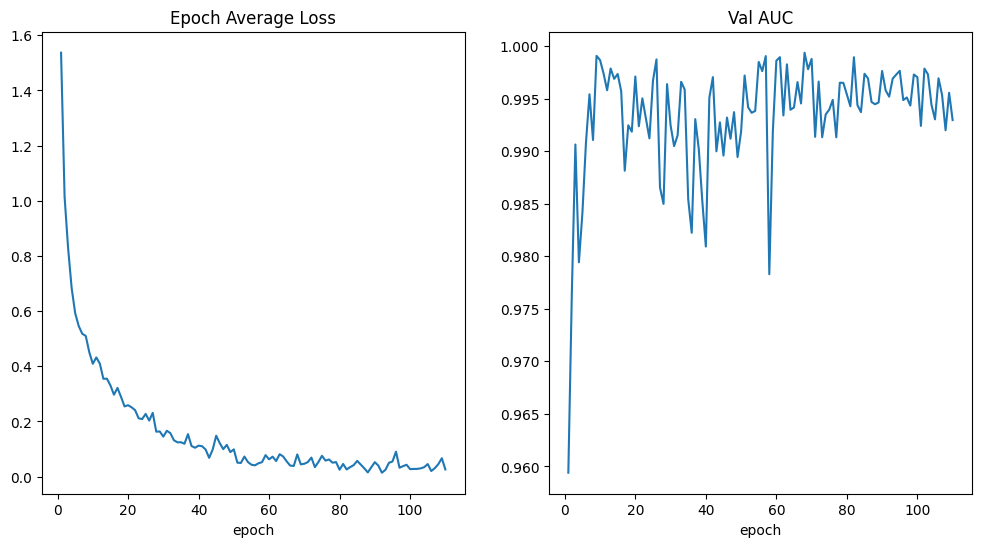

In [40]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [41]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 787.14 MB
Max VRAM used during training: 4506.43 MB


### Evaluate the model on test dataset

In [18]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_3d.pth"), weights_only=True))
model.eval()

y_true = []
y_predicted = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor),
        )

        output = model(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 0.9792


In [19]:
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9718    1.0000    0.9857        69
           1     0.7231    0.6912    0.7068        68
           2     0.6341    0.7536    0.6887        69
           3     0.5521    0.8154    0.6584        65
           4     0.7027    0.4000    0.5098        65
           5     0.9844    0.9545    0.9692        66
           6     1.0000    0.8929    0.9434        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     1.0000    0.8841    0.9385        69
          10     0.9851    0.9565    0.9706        69

    accuracy                         0.8262       610
   macro avg     0.8685    0.8498    0.8519       610
weighted avg     0.8418    0.8262    0.8256       610



In [20]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 563.02 MB
Max VRAM used during training: 12850.32 MB


## Pretrained model

## Training cycle

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=True, spatial_dims=3, n_input_channels=1, 
                 feed_forward=False, shortcut_type='A', bias_downsample=True).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 70
val_interval = 1
auc_metric = ROCAUCMetric()

In [27]:
print(model)

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [28]:
model.avgpool = nn.Sequential(
    model.avgpool,
    nn.Flatten(),
    nn.Linear(512, n_classes)
).to(device)

In [29]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    batch_iter = tqdm(train_loader, desc="Training Batches", leave=False)
    
    for batch_data in batch_iter:
        step += 1
        images, labels = batch_data['images'].to(device), batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        batch_iter.set_postfix(train_loss=loss.item())
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'].to(device),
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_3d_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

----------
epoch 1/70



ining Batches: 100%|██████████| 31/31 [00:23<00:00,  1.63it/s, train_loss=1.84]
                                                                               

epoch 1 average loss: 1.9749
1


Epochs:   1%|▏         | 1/70 [00:25<29:21, 25.53s/it]

saved new best metric model
current epoch: 1 current AUC: 0.7737 current accuracy: 0.1677 best AUC: 0.7737 at epoch: 1
----------
epoch 2/70



ining Batches: 100%|██████████| 31/31 [00:23<00:00,  1.59it/s, train_loss=1.13]
                                                                               

epoch 2 average loss: 1.3986
1


Epochs:   3%|▎         | 2/70 [00:51<29:01, 25.61s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9363 current accuracy: 0.4472 best AUC: 0.9363 at epoch: 2
----------
epoch 3/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.859]
                                                                                

epoch 3 average loss: 1.0765
1


Epochs:   4%|▍         | 3/70 [01:17<28:46, 25.77s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9697 current accuracy: 0.6025 best AUC: 0.9697 at epoch: 3
----------
epoch 4/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=1.62]
                                                                               

epoch 4 average loss: 0.9334
1


Epochs:   6%|▌         | 4/70 [01:43<28:24, 25.82s/it]

saved new best metric model
current epoch: 4 current AUC: 0.9719 current accuracy: 0.6398 best AUC: 0.9719 at epoch: 4
----------
epoch 5/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.59it/s, train_loss=0.821]
                                                                                

epoch 5 average loss: 0.8394
1


Epochs:   7%|▋         | 5/70 [02:09<28:08, 25.97s/it]

saved new best metric model
current epoch: 5 current AUC: 0.9818 current accuracy: 0.7143 best AUC: 0.9818 at epoch: 5
----------
epoch 6/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.764]
                                                                                

epoch 6 average loss: 0.7511
1


Epochs:   9%|▊         | 6/70 [02:35<27:45, 26.02s/it]

saved new best metric model
current epoch: 6 current AUC: 0.9847 current accuracy: 0.7640 best AUC: 0.9847 at epoch: 6
----------
epoch 7/70



ining Batches: 100%|██████████| 31/31 [00:23<00:00,  1.56it/s, train_loss=0.728]
                                                                                

epoch 7 average loss: 0.6727


Epochs:  10%|█         | 7/70 [02:59<26:49, 25.54s/it]

1
current epoch: 7 current AUC: 0.9777 current accuracy: 0.7329 best AUC: 0.9847 at epoch: 6
----------
epoch 8/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.682]
                                                                                

epoch 8 average loss: 0.6328
1


Epochs:  11%|█▏        | 8/70 [03:25<26:32, 25.68s/it]

saved new best metric model
current epoch: 8 current AUC: 0.9868 current accuracy: 0.8447 best AUC: 0.9868 at epoch: 8
----------
epoch 9/70



ining Batches: 100%|██████████| 31/31 [00:23<00:00,  1.58it/s, train_loss=0.6]
                                                                              

epoch 9 average loss: 0.6514
1


Epochs:  13%|█▎        | 9/70 [03:51<26:05, 25.66s/it]

saved new best metric model
current epoch: 9 current AUC: 0.9906 current accuracy: 0.8447 best AUC: 0.9906 at epoch: 9
----------
epoch 10/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.438]
                                                                                

epoch 10 average loss: 0.5726


Epochs:  14%|█▍        | 10/70 [04:16<25:22, 25.37s/it]

1
current epoch: 10 current AUC: 0.9899 current accuracy: 0.8385 best AUC: 0.9906 at epoch: 9
----------
epoch 11/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.502]
                                                                                

epoch 11 average loss: 0.5688
1


Epochs:  16%|█▌        | 11/70 [04:42<25:07, 25.55s/it]

saved new best metric model
current epoch: 11 current AUC: 0.9930 current accuracy: 0.8758 best AUC: 0.9930 at epoch: 11
----------
epoch 12/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.59it/s, train_loss=1.24]
                                                                               

epoch 12 average loss: 0.5527


Epochs:  17%|█▋        | 12/70 [05:06<24:27, 25.31s/it]

1
current epoch: 12 current AUC: 0.9910 current accuracy: 0.8385 best AUC: 0.9930 at epoch: 11
----------
epoch 13/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.453]
                                                                                

epoch 13 average loss: 0.5020


Epochs:  19%|█▊        | 13/70 [05:31<23:51, 25.11s/it]

1
current epoch: 13 current AUC: 0.9905 current accuracy: 0.8571 best AUC: 0.9930 at epoch: 11
----------
epoch 14/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.982]
                                                                                

epoch 14 average loss: 0.4617


Epochs:  20%|██        | 14/70 [05:56<23:19, 24.99s/it]

1
current epoch: 14 current AUC: 0.9902 current accuracy: 0.8571 best AUC: 0.9930 at epoch: 11
----------
epoch 15/70



ining Batches: 100%|██████████| 31/31 [00:23<00:00,  1.55it/s, train_loss=0.633]
                                                                                

epoch 15 average loss: 0.4909


Epochs:  21%|██▏       | 15/70 [06:20<22:46, 24.84s/it]

1
current epoch: 15 current AUC: 0.9917 current accuracy: 0.8571 best AUC: 0.9930 at epoch: 11
----------
epoch 16/70



ining Batches: 100%|██████████| 31/31 [00:23<00:00,  1.58it/s, train_loss=1.18]
                                                                               

epoch 16 average loss: 0.4947


Epochs:  23%|██▎       | 16/70 [06:45<22:17, 24.77s/it]

1
current epoch: 16 current AUC: 0.9904 current accuracy: 0.8882 best AUC: 0.9930 at epoch: 11
----------
epoch 17/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.211]
                                                                                

epoch 17 average loss: 0.4161


Epochs:  24%|██▍       | 17/70 [07:10<21:52, 24.76s/it]

1
current epoch: 17 current AUC: 0.9921 current accuracy: 0.8571 best AUC: 0.9930 at epoch: 11
----------
epoch 18/70



ining Batches: 100%|██████████| 31/31 [00:23<00:00,  1.61it/s, train_loss=0.409]
                                                                                

epoch 18 average loss: 0.4211


Epochs:  26%|██▌       | 18/70 [07:34<21:20, 24.63s/it]

1
current epoch: 18 current AUC: 0.9896 current accuracy: 0.8634 best AUC: 0.9930 at epoch: 11
----------
epoch 19/70



ining Batches: 100%|██████████| 31/31 [00:23<00:00,  1.56it/s, train_loss=0.336]
                                                                                

epoch 19 average loss: 0.3887


Epochs:  27%|██▋       | 19/70 [07:59<20:55, 24.61s/it]

1
current epoch: 19 current AUC: 0.9875 current accuracy: 0.8509 best AUC: 0.9930 at epoch: 11
----------
epoch 20/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.59it/s, train_loss=0.158]
                                                                                

epoch 20 average loss: 0.3749


Epochs:  29%|██▊       | 20/70 [08:23<20:32, 24.66s/it]

1
current epoch: 20 current AUC: 0.9897 current accuracy: 0.8820 best AUC: 0.9930 at epoch: 11
----------
epoch 21/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.514]
                                                                                

epoch 21 average loss: 0.3667


Epochs:  30%|███       | 21/70 [08:48<20:09, 24.69s/it]

1
current epoch: 21 current AUC: 0.9886 current accuracy: 0.8758 best AUC: 0.9930 at epoch: 11
----------
epoch 22/70



ining Batches: 100%|██████████| 31/31 [00:23<00:00,  1.58it/s, train_loss=0.415]
                                                                                

epoch 22 average loss: 0.4146


Epochs:  31%|███▏      | 22/70 [09:13<19:43, 24.65s/it]

1
current epoch: 22 current AUC: 0.9865 current accuracy: 0.8323 best AUC: 0.9930 at epoch: 11
----------
epoch 23/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.859]
                                                                                

epoch 23 average loss: 0.3917


Epochs:  33%|███▎      | 23/70 [09:38<19:22, 24.73s/it]

1
current epoch: 23 current AUC: 0.9892 current accuracy: 0.8696 best AUC: 0.9930 at epoch: 11
----------
epoch 24/70



ining Batches: 100%|██████████| 31/31 [00:23<00:00,  1.59it/s, train_loss=0.478]
                                                                                

epoch 24 average loss: 0.3847


Epochs:  34%|███▍      | 24/70 [10:02<18:54, 24.66s/it]

1
current epoch: 24 current AUC: 0.9884 current accuracy: 0.8634 best AUC: 0.9930 at epoch: 11
----------
epoch 25/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.60it/s, train_loss=0.246]
                                                                                

epoch 25 average loss: 0.3154


Epochs:  36%|███▌      | 25/70 [10:27<18:31, 24.69s/it]

1
current epoch: 25 current AUC: 0.9875 current accuracy: 0.8820 best AUC: 0.9930 at epoch: 11
----------
epoch 26/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.52it/s, train_loss=0.351]
                                                                                

epoch 26 average loss: 0.3431


Epochs:  37%|███▋      | 26/70 [10:52<18:09, 24.75s/it]

1
current epoch: 26 current AUC: 0.9901 current accuracy: 0.8758 best AUC: 0.9930 at epoch: 11
----------
epoch 27/70



ining Batches: 100%|██████████| 31/31 [00:23<00:00,  1.54it/s, train_loss=0.651]
                                                                                

epoch 27 average loss: 0.3456


Epochs:  39%|███▊      | 27/70 [11:16<17:41, 24.69s/it]

1
current epoch: 27 current AUC: 0.9908 current accuracy: 0.8571 best AUC: 0.9930 at epoch: 11
----------
epoch 28/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.504]
                                                                                

epoch 28 average loss: 0.3651


Epochs:  40%|████      | 28/70 [11:41<17:19, 24.75s/it]

1
current epoch: 28 current AUC: 0.9916 current accuracy: 0.8882 best AUC: 0.9930 at epoch: 11
----------
epoch 29/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.52it/s, train_loss=0.507]
                                                                                

epoch 29 average loss: 0.3251


Epochs:  41%|████▏     | 29/70 [12:06<16:56, 24.79s/it]

1
current epoch: 29 current AUC: 0.9916 current accuracy: 0.8820 best AUC: 0.9930 at epoch: 11
----------
epoch 30/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.166]
                                                                                

epoch 30 average loss: 0.3422


Epochs:  43%|████▎     | 30/70 [12:31<16:31, 24.79s/it]

1
current epoch: 30 current AUC: 0.9898 current accuracy: 0.8882 best AUC: 0.9930 at epoch: 11
----------
epoch 31/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.513]
                                                                                

epoch 31 average loss: 0.3142


Epochs:  44%|████▍     | 31/70 [12:55<16:04, 24.74s/it]

1
current epoch: 31 current AUC: 0.9909 current accuracy: 0.8882 best AUC: 0.9930 at epoch: 11
----------
epoch 32/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.59it/s, train_loss=0.335]
                                                                                

epoch 32 average loss: 0.3133


Epochs:  46%|████▌     | 32/70 [13:20<15:40, 24.76s/it]

1
current epoch: 32 current AUC: 0.9890 current accuracy: 0.8385 best AUC: 0.9930 at epoch: 11
----------
epoch 33/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.59it/s, train_loss=0.713]
                                                                                

epoch 33 average loss: 0.3065


Epochs:  47%|████▋     | 33/70 [13:45<15:17, 24.81s/it]

1
current epoch: 33 current AUC: 0.9911 current accuracy: 0.8882 best AUC: 0.9930 at epoch: 11
----------
epoch 34/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.521]
                                                                                

epoch 34 average loss: 0.2929


Epochs:  49%|████▊     | 34/70 [14:10<14:52, 24.79s/it]

1
current epoch: 34 current AUC: 0.9900 current accuracy: 0.8509 best AUC: 0.9930 at epoch: 11
----------
epoch 35/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=1.36]
                                                                               

epoch 35 average loss: 0.3138


Epochs:  50%|█████     | 35/70 [14:35<14:28, 24.80s/it]

1
current epoch: 35 current AUC: 0.9914 current accuracy: 0.8820 best AUC: 0.9930 at epoch: 11
----------
epoch 36/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.397]
                                                                                

epoch 36 average loss: 0.3079


Epochs:  51%|█████▏    | 36/70 [14:59<14:01, 24.76s/it]

1
current epoch: 36 current AUC: 0.9874 current accuracy: 0.8509 best AUC: 0.9930 at epoch: 11
----------
epoch 37/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.338]
                                                                                

epoch 37 average loss: 0.3262


Epochs:  53%|█████▎    | 37/70 [15:24<13:38, 24.79s/it]

1
current epoch: 37 current AUC: 0.9871 current accuracy: 0.8509 best AUC: 0.9930 at epoch: 11
----------
epoch 38/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.52it/s, train_loss=0.361]
                                                                                

epoch 38 average loss: 0.2627


Epochs:  54%|█████▍    | 38/70 [15:49<13:13, 24.79s/it]

1
current epoch: 38 current AUC: 0.9881 current accuracy: 0.8509 best AUC: 0.9930 at epoch: 11
----------
epoch 39/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.142]
                                                                                

epoch 39 average loss: 0.2763


Epochs:  56%|█████▌    | 39/70 [16:14<12:49, 24.84s/it]

1
current epoch: 39 current AUC: 0.9882 current accuracy: 0.8634 best AUC: 0.9930 at epoch: 11
----------
epoch 40/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.53it/s, train_loss=0.18]
                                                                               

epoch 40 average loss: 0.2500


Epochs:  57%|█████▋    | 40/70 [16:39<12:26, 24.87s/it]

1
current epoch: 40 current AUC: 0.9922 current accuracy: 0.8820 best AUC: 0.9930 at epoch: 11
----------
epoch 41/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.58it/s, train_loss=0.268]
                                                                                

epoch 41 average loss: 0.2559


Epochs:  59%|█████▊    | 41/70 [17:04<12:01, 24.88s/it]

1
current epoch: 41 current AUC: 0.9917 current accuracy: 0.8882 best AUC: 0.9930 at epoch: 11
----------
epoch 42/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.58it/s, train_loss=0.176]
                                                                                

epoch 42 average loss: 0.2275


Epochs:  60%|██████    | 42/70 [17:29<11:37, 24.91s/it]

1
current epoch: 42 current AUC: 0.9922 current accuracy: 0.8882 best AUC: 0.9930 at epoch: 11
----------
epoch 43/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.165]
                                                                                

epoch 43 average loss: 0.2088


Epochs:  61%|██████▏   | 43/70 [17:54<11:10, 24.85s/it]

1
current epoch: 43 current AUC: 0.9908 current accuracy: 0.8944 best AUC: 0.9930 at epoch: 11
----------
epoch 44/70



ining Batches: 100%|██████████| 31/31 [00:23<00:00,  1.56it/s, train_loss=0.157]
                                                                                

epoch 44 average loss: 0.2291


Epochs:  63%|██████▎   | 44/70 [18:18<10:42, 24.73s/it]

1
current epoch: 44 current AUC: 0.9925 current accuracy: 0.8882 best AUC: 0.9930 at epoch: 11
----------
epoch 45/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.303]
                                                                                

epoch 45 average loss: 0.2249


Epochs:  64%|██████▍   | 45/70 [18:43<10:17, 24.70s/it]

1
current epoch: 45 current AUC: 0.9897 current accuracy: 0.8944 best AUC: 0.9930 at epoch: 11
----------
epoch 46/70



ining Batches: 100%|██████████| 31/31 [00:23<00:00,  1.60it/s, train_loss=0.487]
                                                                                

epoch 46 average loss: 0.2279


Epochs:  66%|██████▌   | 46/70 [19:07<09:51, 24.64s/it]

1
current epoch: 46 current AUC: 0.9898 current accuracy: 0.8882 best AUC: 0.9930 at epoch: 11
----------
epoch 47/70



ining Batches: 100%|██████████| 31/31 [00:23<00:00,  1.58it/s, train_loss=0.346]
                                                                                

epoch 47 average loss: 0.2395


Epochs:  67%|██████▋   | 47/70 [19:32<09:26, 24.61s/it]

1
current epoch: 47 current AUC: 0.9891 current accuracy: 0.8758 best AUC: 0.9930 at epoch: 11
----------
epoch 48/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.632]
                                                                                

epoch 48 average loss: 0.2587


Epochs:  69%|██████▊   | 48/70 [19:56<09:02, 24.64s/it]

1
current epoch: 48 current AUC: 0.9893 current accuracy: 0.8758 best AUC: 0.9930 at epoch: 11
----------
epoch 49/70



ining Batches: 100%|██████████| 31/31 [00:23<00:00,  1.59it/s, train_loss=0.276]
                                                                                

epoch 49 average loss: 0.2527


Epochs:  70%|███████   | 49/70 [20:21<08:36, 24.61s/it]

1
current epoch: 49 current AUC: 0.9890 current accuracy: 0.8820 best AUC: 0.9930 at epoch: 11
----------
epoch 50/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.269]
                                                                                

epoch 50 average loss: 0.2344


Epochs:  71%|███████▏  | 50/70 [20:46<08:13, 24.68s/it]

1
current epoch: 50 current AUC: 0.9910 current accuracy: 0.8820 best AUC: 0.9930 at epoch: 11
----------
epoch 51/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.53it/s, train_loss=0.151]
                                                                                

epoch 51 average loss: 0.2483


Epochs:  73%|███████▎  | 51/70 [21:11<07:50, 24.75s/it]

1
current epoch: 51 current AUC: 0.9904 current accuracy: 0.8882 best AUC: 0.9930 at epoch: 11
----------
epoch 52/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.245]
                                                                                

epoch 52 average loss: 0.2240


Epochs:  74%|███████▍  | 52/70 [21:36<07:27, 24.84s/it]

1
current epoch: 52 current AUC: 0.9920 current accuracy: 0.8820 best AUC: 0.9930 at epoch: 11
----------
epoch 53/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.52it/s, train_loss=0.736]
                                                                                

epoch 53 average loss: 0.2445
1


Epochs:  76%|███████▌  | 53/70 [22:02<07:07, 25.17s/it]

saved new best metric model
current epoch: 53 current AUC: 0.9959 current accuracy: 0.9068 best AUC: 0.9959 at epoch: 53
----------
epoch 54/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.54it/s, train_loss=0.344]
                                                                                

epoch 54 average loss: 0.2431


Epochs:  77%|███████▋  | 54/70 [22:27<06:41, 25.07s/it]

1
current epoch: 54 current AUC: 0.9910 current accuracy: 0.8634 best AUC: 0.9959 at epoch: 53
----------
epoch 55/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.434]
                                                                                

epoch 55 average loss: 0.2132


Epochs:  79%|███████▊  | 55/70 [22:51<06:14, 24.99s/it]

1
current epoch: 55 current AUC: 0.9929 current accuracy: 0.8882 best AUC: 0.9959 at epoch: 53
----------
epoch 56/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.131]
                                                                                

epoch 56 average loss: 0.2202


Epochs:  80%|████████  | 56/70 [23:16<05:49, 24.93s/it]

1
current epoch: 56 current AUC: 0.9911 current accuracy: 0.8758 best AUC: 0.9959 at epoch: 53
----------
epoch 57/70



ining Batches: 100%|██████████| 31/31 [00:23<00:00,  1.60it/s, train_loss=0.14]
                                                                               

epoch 57 average loss: 0.1770


Epochs:  81%|████████▏ | 57/70 [23:41<05:22, 24.79s/it]

1
current epoch: 57 current AUC: 0.9902 current accuracy: 0.9068 best AUC: 0.9959 at epoch: 53
----------
epoch 58/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.60it/s, train_loss=0.274]
                                                                                

epoch 58 average loss: 0.1783


Epochs:  83%|████████▎ | 58/70 [24:05<04:56, 24.74s/it]

1
current epoch: 58 current AUC: 0.9906 current accuracy: 0.8634 best AUC: 0.9959 at epoch: 53
----------
epoch 59/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.52it/s, train_loss=0.206]
                                                                                

epoch 59 average loss: 0.2005


Epochs:  84%|████████▍ | 59/70 [24:30<04:32, 24.76s/it]

1
current epoch: 59 current AUC: 0.9918 current accuracy: 0.8944 best AUC: 0.9959 at epoch: 53
----------
epoch 60/70



ining Batches: 100%|██████████| 31/31 [00:23<00:00,  1.57it/s, train_loss=0.137]
                                                                                

epoch 60 average loss: 0.1910


Epochs:  86%|████████▌ | 60/70 [24:54<04:06, 24.63s/it]

1
current epoch: 60 current AUC: 0.9916 current accuracy: 0.8882 best AUC: 0.9959 at epoch: 53
----------
epoch 61/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.58it/s, train_loss=0.439]
                                                                                

epoch 61 average loss: 0.2091


Epochs:  87%|████████▋ | 61/70 [25:19<03:42, 24.72s/it]

1
current epoch: 61 current AUC: 0.9928 current accuracy: 0.8758 best AUC: 0.9959 at epoch: 53
----------
epoch 62/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.57it/s, train_loss=0.09]
                                                                               

epoch 62 average loss: 0.1814


Epochs:  89%|████████▊ | 62/70 [25:44<03:18, 24.78s/it]

1
current epoch: 62 current AUC: 0.9881 current accuracy: 0.8571 best AUC: 0.9959 at epoch: 53
----------
epoch 63/70



ining Batches: 100%|██████████| 31/31 [00:23<00:00,  1.62it/s, train_loss=0.04]
                                                                               

epoch 63 average loss: 0.1854


Epochs:  90%|█████████ | 63/70 [26:09<02:52, 24.67s/it]

1
current epoch: 63 current AUC: 0.9906 current accuracy: 0.8820 best AUC: 0.9959 at epoch: 53
----------
epoch 64/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.50it/s, train_loss=0.118]
                                                                                

epoch 64 average loss: 0.1800


Epochs:  91%|█████████▏| 64/70 [26:33<02:28, 24.72s/it]

1
current epoch: 64 current AUC: 0.9891 current accuracy: 0.8820 best AUC: 0.9959 at epoch: 53
----------
epoch 65/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.55it/s, train_loss=0.592]
                                                                                

epoch 65 average loss: 0.2115


Epochs:  93%|█████████▎| 65/70 [26:58<02:03, 24.77s/it]

1
current epoch: 65 current AUC: 0.9916 current accuracy: 0.8758 best AUC: 0.9959 at epoch: 53
----------
epoch 66/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.56it/s, train_loss=0.191]
                                                                                

epoch 66 average loss: 0.2235


Epochs:  94%|█████████▍| 66/70 [27:23<01:39, 24.82s/it]

1
current epoch: 66 current AUC: 0.9906 current accuracy: 0.8758 best AUC: 0.9959 at epoch: 53
----------
epoch 67/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.51it/s, train_loss=0.634]
                                                                                

epoch 67 average loss: 0.1869


Epochs:  96%|█████████▌| 67/70 [27:48<01:14, 24.79s/it]

1
current epoch: 67 current AUC: 0.9918 current accuracy: 0.8944 best AUC: 0.9959 at epoch: 53
----------
epoch 68/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.60it/s, train_loss=0.273]
                                                                                

epoch 68 average loss: 0.1949


Epochs:  97%|█████████▋| 68/70 [28:13<00:49, 24.80s/it]

1
current epoch: 68 current AUC: 0.9952 current accuracy: 0.9068 best AUC: 0.9959 at epoch: 53
----------
epoch 69/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.61it/s, train_loss=0.165]
                                                                                

epoch 69 average loss: 0.1863


Epochs:  99%|█████████▊| 69/70 [28:38<00:24, 24.81s/it]

1
current epoch: 69 current AUC: 0.9918 current accuracy: 0.8944 best AUC: 0.9959 at epoch: 53
----------
epoch 70/70



ining Batches: 100%|██████████| 31/31 [00:24<00:00,  1.53it/s, train_loss=0.605]
                                                                                

epoch 70 average loss: 0.1794


Epochs: 100%|██████████| 70/70 [29:02<00:00, 24.90s/it]

1
current epoch: 70 current AUC: 0.9917 current accuracy: 0.8758 best AUC: 0.9959 at epoch: 53
train completed, best_metric: 0.9959 at epoch: 53


In [30]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 1742.94 seconds
CPU time used: 14937.51 seconds
Memory used: 391.32 MB
GPU Memory Used: 793.94 MB
Max GPU Memory Used: 13104.66 MB


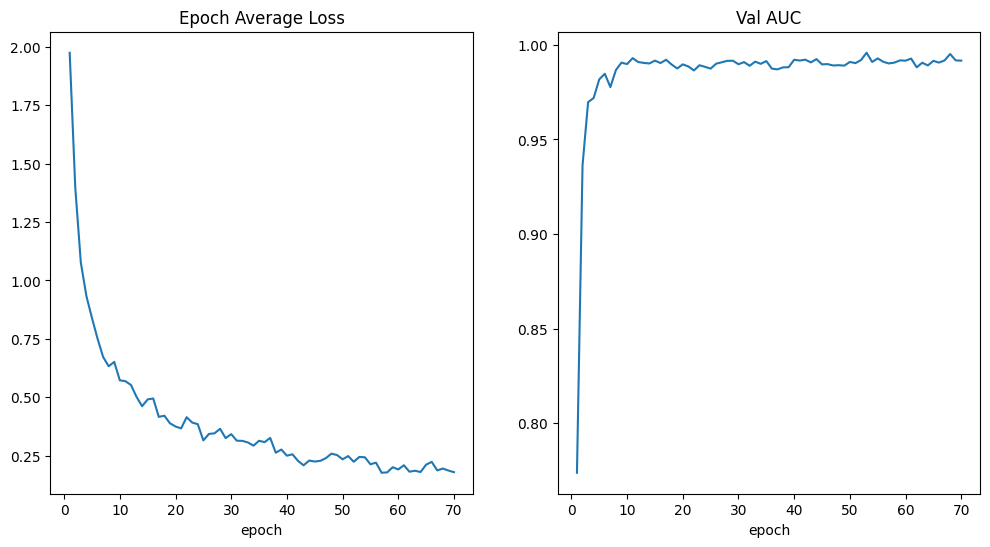

In [31]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [32]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 793.94 MB
Max VRAM used during training: 13104.66 MB


### Evaluate the model on test dataset

In [33]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_3d_pretrained.pth"), weights_only=True))
model.eval()

y_true = []
y_predicted = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor),
        )

        output = model(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 0.9838


In [34]:
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9857    1.0000    0.9928        69
           1     0.7069    0.6029    0.6508        68
           2     0.6329    0.7246    0.6757        69
           3     0.7115    0.5692    0.6325        65
           4     0.6429    0.6923    0.6667        65
           5     0.9394    0.9394    0.9394        66
           6     1.0000    0.8214    0.9020        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     0.9041    0.9565    0.9296        69
          10     0.8961    1.0000    0.9452        69

    accuracy                         0.8262       610
   macro avg     0.8563    0.8460    0.8486       610
weighted avg     0.8262    0.8262    0.8237       610



In [35]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 540.74 MB
Max VRAM used during training: 13104.66 MB
